# CycleGAN

In [0]:
pip install -q git+https://github.com/tensorflow/examples.git


In [0]:
import tensorflow as tf

In [0]:
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

In [0]:
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
AUTOTUNE= tf.data.experimental.AUTOTUNE 

In [0]:
dataset, metadata = tfds.load('cycle_gan/horse2zebra',with_info=True, as_supervised=True)


In [0]:
dataset

{'testA': <DatasetV1Adapter shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>,
 'testB': <DatasetV1Adapter shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>,
 'trainA': <DatasetV1Adapter shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>,
 'trainB': <DatasetV1Adapter shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>}

In [0]:
horses_train,horses_test=dataset["trainA"],dataset["testA"]

In [0]:
zebras_train,zebras_test=dataset["trainB"],dataset["testB"]

In [0]:
def noofsamples(data):
  i=0
  for x,y in data:
    i+=1
  return i


In [0]:
print("There are {} no of training horse samples".format(noofsamples(horses_train)))
print("There are {} no of training zebras samples".format(noofsamples(zebras_train)))

There are 1067 no of training horse samples
There are 1334 no of training zebras samples


In [0]:
def samples_snapshot(data,take):
  i=1
  for x,y in data.take(take):
    plt.subplot(1,take,i)
    plt.imshow(x)
    i+=1

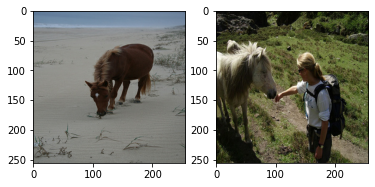

In [0]:
samples_snapshot(horses_train,2)


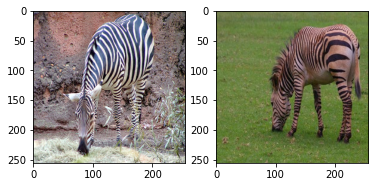

In [0]:
samples_snapshot(zebras_train,2)

In [0]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256


In [0]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256


In [0]:
def normalize(image):
  image=tf.cast(image,tf.float32)
  image=(image/127.5)-1
  return image

In [0]:
def random_resize_crop(image):
  #image.shape>size so we resize image first
  return tf.image.random_crop(image,size=[IMG_HEIGHT,IMG_WIDTH,3])

In [0]:
def random_jitter(image):
  #resize first for valid crop
  image=tf.image.resize(image,[290,290],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  image=random_resize_crop(image)
  return image


In [0]:
def preprocess_train(image,label):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [0]:
def preprocess_test(image,label):
  image = normalize(image)
  return image

In [0]:
horses_train = horses_train.map(preprocess_train,num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).batch(1)
zebras_train = zebras_train.map(preprocess_train,num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).batch(1)
horses_test = horses_test.map(preprocess_test,num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).batch(1)
zebras_test = zebras_test.map(preprocess_test,num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).batch(1)

In [0]:
horses_train

<DatasetV1Adapter shapes: (None, 256, 256, 3), types: tf.float32>

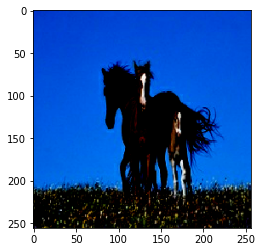

In [0]:
for x in horses_train.take(1):
  sample_horse=x
  plt.imshow(x[0])

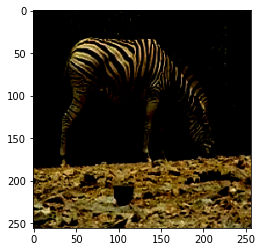

In [0]:
for x in zebras_train.take(2):
  sample_zebras=x
  plt.imshow(x[0])

In [0]:
OUTPUT_CHANNELS=3

In [0]:
generator_g=pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type="instancenorm")
generator_f=pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type="instancenorm")
discriminator_x=pix2pix.discriminator(norm_type="instancenorm", target=False)
discriminator_y=pix2pix.discriminator(norm_type="instancenorm",target=False)

# LOSS FUNCTION

In [0]:
loss=tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
def discriminator_loss(real,generated):
  Ed = loss(tf.ones_like(real),real)
  Eg = loss(tf.zeros_like(generated),generated)
  Etot = Ed+Eg
  return Etot*0.5

In [0]:
def generator_loss(generated):
  return loss(tf.ones_like(generated),generated)

In [0]:
def clac_cycle_loss(generated,cycle):
  closs= tf.reduce_mean(tf.abs(generated-cycle))
  return closs*10


In [0]:
def identity_loss(real,same):
  iloss = tf.reduce_mean(tf.abs(real-same))
  return 10*0.5*iloss

In [0]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4,beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4,beta_1=0.5)
discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4,beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4,beta_1=0.5)

In [0]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')


In [0]:
EPOCHS=40

In [0]:
def generated_images(model,test_input):
  prediction = model(test_input)
  plt.figure(figsize=(12,12))
  display = [test_input[0],prediction[0]]
  title_list=["Input Image","Converted_image"]
  for i in range(2):
    plt.subplot(1,2,i+1)
    plt.title(title_list[i])
    plt.imshow(display[i]*0.5+0.5)
  plt.show()

# How this work
So to get our work done we first take a particular category image and push it through a generator(horses->generated horses)

So we get somewhat an image now to transfer it into a different domain we push it to another generator of different domain(generated horses->zebras)

At the same time we train the generator to make a image of its own domain(horses->horses)


In [0]:
@tf.function
def train_step(x,y):
  with tf.GradientTape(persistent=True) as tape:
    fake_x=generator_g(x,training =True)
    cycled_y=generator_f(x,training=True)

    fake_y=generator_f(y,training=True)
    cycled_x=generator_g(x,training=True)

    same_x = generator_g(x,training=True)
    same_y = generator_f(y,training=True)

    disx_=discriminator_x(x,training=True)
    disy_=discriminator_y(y,training=True)

    dis_y_x= discriminator_x(fake_y,training=True)
    dis_x_y= discriminator_y(fake_x,training=True)

    gan_g_loss= generator_loss(dis_x_y)
    gan_f_loss= generator_loss(dis_y_x)

    total_loss = clac_cycle_loss(x,cycled_y)+clac_cycle_loss(y,cycled_x)

    total_gan_g_loss=gan_g_loss+total_loss+identity_loss(y,same_y)
    total_gan_f_loss=gan_f_loss+total_loss+identity_loss(x,same_x)

    dis_x_loss = discriminator_loss(disx_,dis_y_x)
    dis_y_loss = discriminator_loss(disy_,dis_x_y)


  
  gan_g_grad = tape.gradient(total_gan_g_loss,generator_g.trainable_variables)
  gan_f_grad = tape.gradient(total_gan_f_loss,generator_f.trainable_variables)
  dis_x_grad = tape.gradient(dis_x_loss,discriminator_x.trainable_variables)
  dis_y_grad = tape.gradient(dis_y_loss,discriminator_y.trainable_variables)

  generator_g_optimizer.apply_gradients(zip(gan_g_grad,generator_g.trainable_variables))
  generator_f_optimizer.apply_gradients(zip(gan_f_grad,generator_f.trainable_variables))
  discriminator_x_optimizer.apply_gradients(zip(dis_x_grad,discriminator_x.trainable_variables))
  discriminator_y_optimizer.apply_gradients(zip(dis_y_grad,discriminator_y.trainable_variables))


    


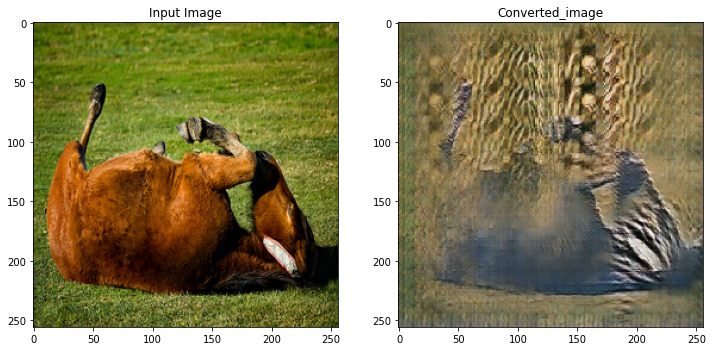

Time 520.1047382354736


In [0]:
for epoch in range(30):
  start = time.time()
  print("EPOCH:",epoch+1)
  n=0
  for image_x,image_y in tf.data.Dataset.zip((horses_train,zebras_train)):
    
    train_step(image_x,image_y)
    if(n%200==0):
      print(".",end="")
    n+=1

  clear_output(wait=True)
  sample_horse_=next(iter(horses_test))
  generated_images(generator_g,sample_horse_)

  if(epoch+1)%5==0:
    ckpt_save_path=ckpt_manager.save()
  print("Time",time.time()-start)


In [0]:
!ls /content/checkpoints/train/

checkpoint		    ckpt-4.data-00001-of-00002
ckpt-2.data-00000-of-00002  ckpt-4.index
ckpt-2.data-00001-of-00002  ckpt-5.data-00000-of-00002
ckpt-2.index		    ckpt-5.data-00001-of-00002
ckpt-3.data-00000-of-00002  ckpt-5.index
ckpt-3.data-00001-of-00002  ckpt-6.data-00000-of-00002
ckpt-3.index		    ckpt-6.data-00001-of-00002
ckpt-4.data-00000-of-00002  ckpt-6.index


In [60]:
!zip -r /content/file.zip /content/checkpoints

updating: content/checkpoints/ (stored 0%)
updating: content/checkpoints/train/ (stored 0%)
updating: content/checkpoints/train/ckpt-4.data-00000-of-00002 (deflated 90%)
updating: content/checkpoints/train/checkpoint (deflated 71%)
updating: content/checkpoints/train/ckpt-5.data-00001-of-00002 (deflated 21%)
updating: content/checkpoints/train/ckpt-6.data-00000-of-00002 (deflated 90%)
updating: content/checkpoints/train/ckpt-4.index (deflated 82%)
updating: content/checkpoints/train/ckpt-6.index (deflated 82%)
updating: content/checkpoints/train/ckpt-3.data-00001-of-00002 (deflated 21%)
updating: content/checkpoints/train/ckpt-2.index (deflated 82%)
updating: content/checkpoints/train/ckpt-3.data-00000-of-00002 (deflated 90%)
updating: content/checkpoints/train/ckpt-6.data-00001-of-00002 (deflated 21%)
updating: content/checkpoints/train/ckpt-3.index (deflated 82%)
updating: content/checkpoints/train/ckpt-5.data-00000-of-00002 (deflated 90%)
updating: content/checkpoints/train/ckpt-5.i